In [1]:
import ConfigParser
from datetime import datetime
import os
import sys
import time

import numpy as np
import pandas as pd
from sklearn import preprocessing, svm

# Extend sys.path for relative imports
sys.path.extend(["/Users/daddy30000/dev/ucb_smartcities_all/sandbox/neverforgit/src/main/python/CanonicalSmartBay/"])
import utils.counts as counts

In order to use the OneClassSVM for outlier_detection and station filtering, we need to decide on two hyperparameters (besides the usual nu and gamma):   

1) distance from hyperplane to declare an outlier

2) threshold for the fraction of "outlier" days that will trigger removal of the station.

Another question to consider is how to conduct the filtering. Should simply remove any station that has even a single extreme outlier? Should we only remove those days and still keep the station?

In [2]:
ts_dir = "/Users/daddy30000/dev/data/PeMS/SmartBay/time_series/2015_all/"
# ts_dir = "/Users/daddy30000/dev/data/PeMS/SmartBay/time_series/big_test/"
config_path = "/Users/daddy30000/dev/ucb_smartcities_all/sandbox/neverforgit/src/main/python/CanonicalSmartBay/config/config_test_filters.ini"

In [3]:
##
# Load values from config file
##
conf = ConfigParser.ConfigParser()
conf.read(config_path)

# Paths
meta_path = conf.get('Paths', 'meta_path')
stat_link_map_path = conf.get('Paths', 'stat_link_map_path')
ts_dir = conf.get('Paths', 'ts_dir')  # Path to station Time Series
out_cleaned_path = conf.get('Paths', 'out_cleaned_path')  # Where to write the results of filtering
out_removed_path = conf.get('Paths', 'out_removed_path')  # Where to write the results of filtering
out_log_path = conf.get('Paths', 'out_log_path')  # Where to write the results of filtering
poly_path = conf.get('Paths', 'poly_path')  # Where to write the results of filtering

# Parameters
start_date = datetime.strptime(conf.get('Params', 'start_date'), '%Y/%m/%d')
end_date = datetime.strptime(conf.get('Params', 'end_date'), '%Y/%m/%d')
weekdays = [int(d) for d in [s.strip() for s in conf.get('Params', 'weekdays').split(',')]]
counts_year = conf.get('Params', 'counts_year')

date_list = counts.date_string_list(start_date, end_date, weekdays)

The method is train a OneClassSVM w/ defaults on every station. We then calculate the distance for each day in that station's training set and compare them with the other stations. This will produce two data objects:

1) Station: [distances] (should probably be a dict since the number of days in distances may vary accross stations if I haven't already applied the date_range and missing_data filters)

2) Station: histogram (DataFrame) 

The trick with the second object is determining the bins for the histograms. It will first be necessary to inspect the first object.

In [4]:
# Initialize OneClassSVM w/ defaults
clf = svm.OneClassSVM()

In [5]:
orig_dir = os.getcwd()
os.chdir(ts_dir)

In [6]:
#data structures
stations = [n for n in os.listdir('.') if n.isdigit()]  # list of all station folder names
dists_dict = {}

In [7]:
##
# Iterate through all the stations and calculate the distances
##
t0 = time.time()
for i, stat in enumerate(stations[0:1500]):
    if not i%10:
        print "Processing station %s" % (stat)
    # Load the time series df and process
    ts_df = pd.read_csv('./%s/time_series.csv' % stat, index_col='Timestamp')
    ts_df['date'] = [d[0:10] for d in ts_df.index]
    ts_df['hour'] = [d[-8:-6] for d in ts_df.index]
    vol_5min = ts_df[ts_df['date'].isin(date_list)][['Total_Flow', 'hour', 'date']] # all 5-min observations on desired dates
    vol_5min.index = pd.to_datetime(vol_5min.index)
    ##
    # Create the feature matrix, X
    ##
    
    # Group by dates
    groups = vol_5min.groupby(['date'])
    n = len(groups.groups.keys())  # number of unique groups
    X = np.empty((n, 24))  # Feature vector n x p
    for i, (dt, g) in enumerate(groups):
        # dt is a date string, g is dataframe
        X[i,:] = g.resample('1h').sum().values.flatten()  # Rollup the 5-minute counts to 1-hr
    # Scale and center the data
    preprocessing.scale(X, axis=1, copy=False)
    # Train and recorded distances
    clf.fit(X)
    dists_dict[stat] = clf.decision_function(X)
    t1 = time.time()
print "Time to test %d stations: %d [sec]" % (len(stations), t1 - t0)


Processing station 400000
Processing station 400017
Processing station 400040
Processing station 400057
Processing station 400078
Processing station 400094
Processing station 400106
Processing station 400118
Processing station 400137
Processing station 400152
Processing station 400171
Processing station 400185
Processing station 400203
Processing station 400216
Processing station 400232
Processing station 400251
Processing station 400265
Processing station 400284
Processing station 400301
Processing station 400316
Processing station 400330
Processing station 400341
Processing station 400363
Processing station 400389
Processing station 400406
Processing station 400421
Processing station 400437
Processing station 400448
Processing station 400463
Processing station 400484
Processing station 400497
Processing station 400514
Processing station 400534
Processing station 400550
Processing station 400568
Processing station 400581
Processing station 400606
Processing station 400620
Processing s

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [9]:
len(dists_dict.keys())

620

In [21]:
dists_dict_bak = dists_dict

In [25]:
for k in dists_dict.keys():
    dists_dict[k] = dists_dict[k].flatten()

In [26]:
dists_dict[k]

array([  1.71441531e-01,   1.86901221e-01,   1.77463907e-01,
        -3.45958568e-08,  -9.31126053e-02,   1.33341158e-01,
         1.56299663e-01,   1.46866080e-01,   1.54349597e-01,
         1.81066293e-01,   4.89466805e-02,   1.50790608e-01,
        -1.33179775e+00,   1.84636905e-01,  -3.20083556e-01,
         1.21725530e-01,  -8.94369290e-01,  -5.31892528e+00,
        -5.80619214e-02,   1.20657573e-01,  -1.62470070e+00,
         2.05883459e-01,  -2.59660022e-01,  -6.44562696e-03,
        -2.23243764e-01,  -3.17072773e-02,  -1.29592864e+00,
         2.58553018e-02,  -4.23068064e+00,  -1.23972822e+00,
         2.14990511e-01,   1.18213708e-01,   1.59762033e-01,
        -6.29479437e-08,  -2.88725633e-01,  -5.52971012e-01,
        -2.99718337e-01,  -1.59263387e+00,   1.59356927e-01])

## The following block is a bunch of cleaning for the first 619 stations that ran. If you need to repeat this analysis, start by reading the cvs written below instead of running the OneClassSVM filter all over again.

Remove the one observation w/ only 6 days.

In [32]:
v_lens = np.array([dists_dict[k].shape for k in dists_dict.keys()])

In [34]:
idx_short = np.argmin(v_lens)
idx_short

288

In [35]:
dists_dict.pop(dists_dict.keys()[idx_short])

array([ 0.00225469,  0.01474937, -0.00225471, -0.50338637,  0.01651892,
       -0.00225471])

In [37]:
dists_df = pd.DataFrame.from_dict(dists_dict)

In [39]:
dists_df.to_csv("/Users/daddy30000/dev/data/PeMS/SmartBay/test/OneClassSVM_dists.csv", index=False)

In [40]:
np.min(dists_dict.values())

-15.770117018750398

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [45]:
dists = np.array(dists_dict.values())

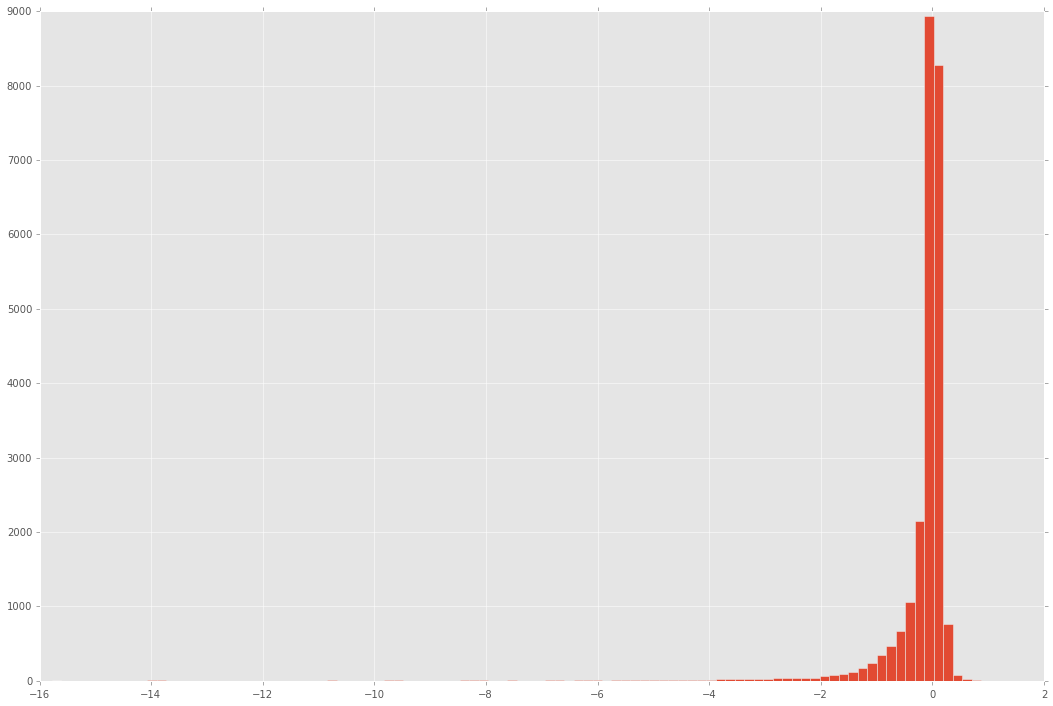

In [53]:
plt.figure(figsize=(18,12))
plt.hist(dists.flatten(), bins=100);

In [56]:
n_days = dists.shape[0]*dists.shape[1]
print n_days
n_4 = np.sum(dists < -4)
print n_4
print np.true_divide(n_4, n_days)

24141
273
0.0113085621971


It appears that -4 is a good outlier. It captures 1.1% of the days observed.

In [59]:
decision_dist = -4

## The next step is to look for sensors with a preponderance of outlier days. Determine a good threshold.

In [76]:
# Which sensors have outlier days?
outlier_stats = [k for k in dists_dict.keys() if np.any(dists_dict[k] < decision_dist)]

In [77]:
len(outlier_stats)

180

In [78]:
num_outliers = [np.sum(dists_dict[k] < decision_dist) for k in outlier_stats]

Now the next step is to actually see which stations have the most decision_dist outlier days and manually inspect their time series.

In [79]:
out_dict = dict(zip(outlier_stats, num_outliers))

In [121]:
out_dict

{'400002': 1,
 '400011': 1,
 '400028': 1,
 '400040': 3,
 '400045': 1,
 '400050': 1,
 '400065': 3,
 '400067': 1,
 '400069': 1,
 '400075': 3,
 '400082': 1,
 '400084': 1,
 '400085': 1,
 '400091': 2,
 '400093': 2,
 '400106': 1,
 '400108': 1,
 '400109': 1,
 '400112': 1,
 '400126': 1,
 '400128': 2,
 '400162': 1,
 '400164': 1,
 '400168': 1,
 '400169': 1,
 '400178': 1,
 '400182': 1,
 '400190': 3,
 '400193': 1,
 '400201': 2,
 '400202': 1,
 '400208': 1,
 '400209': 1,
 '400211': 1,
 '400223': 2,
 '400235': 1,
 '400236': 1,
 '400257': 2,
 '400260': 1,
 '400261': 5,
 '400265': 2,
 '400284': 1,
 '400287': 2,
 '400292': 1,
 '400295': 1,
 '400297': 2,
 '400302': 3,
 '400308': 3,
 '400309': 1,
 '400313': 1,
 '400317': 2,
 '400319': 2,
 '400337': 2,
 '400339': 1,
 '400341': 3,
 '400343': 1,
 '400350': 1,
 '400359': 3,
 '400369': 1,
 '400372': 2,
 '400376': 4,
 '400378': 1,
 '400380': 3,
 '400381': 1,
 '400382': 4,
 '400389': 1,
 '400394': 1,
 '400400': 1,
 '400409': 1,
 '400411': 1,
 '400413': 1,
 '4004

In [86]:
# Sorted in order of decreasing number of outlier days
idx_sorted = sorted(out_dict, key=out_dict.__getitem__, reverse=True)

In [87]:

idx_sorted

['400733',
 '400261',
 '400859',
 '401017',
 '400382',
 '400492',
 '401100',
 '400829',
 '400376',
 '400837',
 '400728',
 '400302',
 '400308',
 '401084',
 '400075',
 '400190',
 '400359',
 '400815',
 '400380',
 '400341',
 '400065',
 '400607',
 '401070',
 '400040',
 '400669',
 '400223',
 '400675',
 '400980',
 '400337',
 '400734',
 '400641',
 '400646',
 '400201',
 '400551',
 '400128',
 '400287',
 '400495',
 '400297',
 '400265',
 '400637',
 '400639',
 '400723',
 '400535',
 '400948',
 '400372',
 '400601',
 '400765',
 '400519',
 '400091',
 '400093',
 '400317',
 '400319',
 '400257',
 '400852',
 '400309',
 '401018',
 '400576',
 '400574',
 '400575',
 '400785',
 '400784',
 '400720',
 '400028',
 '400474',
 '400389',
 '400707',
 '400679',
 '400902',
 '400677',
 '400907',
 '400673',
 '400182',
 '400865',
 '400656',
 '400547',
 '400339',
 '400883',
 '400886',
 '400567',
 '400235',
 '400568',
 '400236',
 '400730',
 '400731',
 '400409',
 '401081',
 '401083',
 '400978',
 '400972',
 '400488',
 '401058',

## For each station w/ 2 or more outlier days, get the dates of their outliers for manual inspection

In [113]:
a= np.extract(dists_dict['400733'] < -4, date_list)

In [115]:
a.tolist()

['06/09/2015', '07/15/2015', '07/16/2015', '07/21/2015', '07/28/2015']

In [125]:
outlier_dates = {key: np.extract(dists_dict[key] < -4, date_list).tolist() for key in out_dict.keys()}

In [131]:
outlier_dates = {key: np.extract(dists_dict[key] < -4, date_list).tolist() for key in out_dict.keys() 
                if out_dict[key] > 2}

In [117]:
outlier_dates

{'400002': ['08/27/2015'],
 '400011': ['08/27/2015'],
 '400028': ['07/07/2015'],
 '400040': ['07/16/2015', '07/21/2015', '08/20/2015'],
 '400045': ['07/02/2015'],
 '400050': ['08/27/2015'],
 '400065': ['06/03/2015', '07/15/2015', '07/21/2015'],
 '400067': ['08/05/2015'],
 '400069': ['07/23/2015'],
 '400075': ['08/04/2015', '08/05/2015', '08/06/2015'],
 '400082': ['08/06/2015'],
 '400084': ['07/23/2015'],
 '400085': ['07/23/2015'],
 '400091': ['07/23/2015', '08/27/2015'],
 '400093': ['07/23/2015', '08/19/2015'],
 '400106': ['07/21/2015'],
 '400108': ['07/01/2015'],
 '400109': ['07/23/2015'],
 '400112': ['08/18/2015'],
 '400126': ['07/07/2015'],
 '400128': ['07/14/2015', '08/11/2015'],
 '400162': ['06/04/2015'],
 '400164': ['08/18/2015'],
 '400168': ['08/06/2015'],
 '400169': ['08/05/2015'],
 '400178': ['08/18/2015'],
 '400182': ['06/30/2015'],
 '400190': ['08/04/2015', '08/05/2015', '08/20/2015'],
 '400193': ['07/01/2015'],
 '400201': ['08/13/2015', '08/27/2015'],
 '400202': ['08/27/201

In [132]:
outlier_dates

{'400040': ['07/16/2015', '07/21/2015', '08/20/2015'],
 '400065': ['06/03/2015', '07/15/2015', '07/21/2015'],
 '400075': ['08/04/2015', '08/05/2015', '08/06/2015'],
 '400190': ['08/04/2015', '08/05/2015', '08/20/2015'],
 '400261': ['06/30/2015',
  '07/01/2015',
  '07/09/2015',
  '07/23/2015',
  '08/06/2015'],
 '400302': ['07/02/2015', '07/09/2015', '08/06/2015'],
 '400308': ['07/02/2015', '07/09/2015', '08/06/2015'],
 '400341': ['08/04/2015', '08/05/2015', '08/20/2015'],
 '400359': ['07/02/2015', '07/23/2015', '07/28/2015'],
 '400376': ['08/04/2015', '08/05/2015', '08/06/2015', '08/18/2015'],
 '400380': ['06/24/2015', '06/25/2015', '08/27/2015'],
 '400382': ['07/14/2015', '08/04/2015', '08/12/2015', '08/13/2015'],
 '400492': ['06/30/2015', '07/01/2015', '07/09/2015', '07/23/2015'],
 '400607': ['08/04/2015', '08/05/2015', '08/20/2015'],
 '400669': ['08/04/2015', '08/05/2015', '08/20/2015'],
 '400728': ['06/10/2015', '06/11/2015', '07/07/2015', '08/20/2015'],
 '400733': ['06/09/2015',
  

In [133]:
# Write them to an output file
with open('/Users/daddy30000/dev/data/PeMS/SmartBay/test/outlier_dates.csv', 'w') as fo:
    for stat in outlier_dates.items():
        fo.write(str(stat)[1:-1] + '\n')

## Write the distances for the outlier dates

In [134]:
outlier_dists = {key: np.extract(dists_dict[key] < -4, dists_dict[key]).tolist() for key in out_dict.keys() 
                if out_dict[key] > 2}

In [135]:
outlier_dists

{'400040': [-5.14896295338295, -8.564642615786054, -13.88347178803934],
 '400065': [-4.0596558721816525, -4.190835547924676, -4.876221891150749],
 '400075': [-8.158876761995518, -6.866991120807564, -4.589576075557149],
 '400190': [-5.360733425575713, -13.33649309995437, -9.537977217838002],
 '400261': [-9.470126185689395,
  -6.90752644255085,
  -11.117689927130598,
  -5.218927886104451,
  -10.969104339074903],
 '400302': [-12.610019582548329, -13.12328244751752, -8.855428499066738],
 '400308': [-8.383069370796036, -13.771285193536563, -10.808983384008364],
 '400341': [-6.366278955143052, -12.449663416599554, -10.761085832072325],
 '400359': [-13.322220964369045, -4.486090583672814, -4.159667486435037],
 '400376': [-7.769324377128548,
  -7.679673328769409,
  -7.51344685408853,
  -7.207567129742905],
 '400380': [-8.936626320298366, -7.467991042212365, -4.881082802333253],
 '400382': [-5.677263124253761,
  -5.916156897732089,
  -5.589986960062683,
  -5.462738896858097],
 '400492': [-10.25

In [136]:
# Write them to an output file
with open('/Users/daddy30000/dev/data/PeMS/SmartBay/test/outlier_dists.csv', 'w') as fo:
    for stat in outlier_dists.items():
        fo.write(str(stat)[1:-1] + '\n')

## Creating Histogram from the output file

In [5]:
dists_df = pd.read_csv("/Users/daddy30000/dev/data/PeMS/SmartBay/test/OneClassSVM_dists.csv")

In [8]:
dists = dists_df.values.flatten()

In [9]:
dists.shape

(24141,)

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

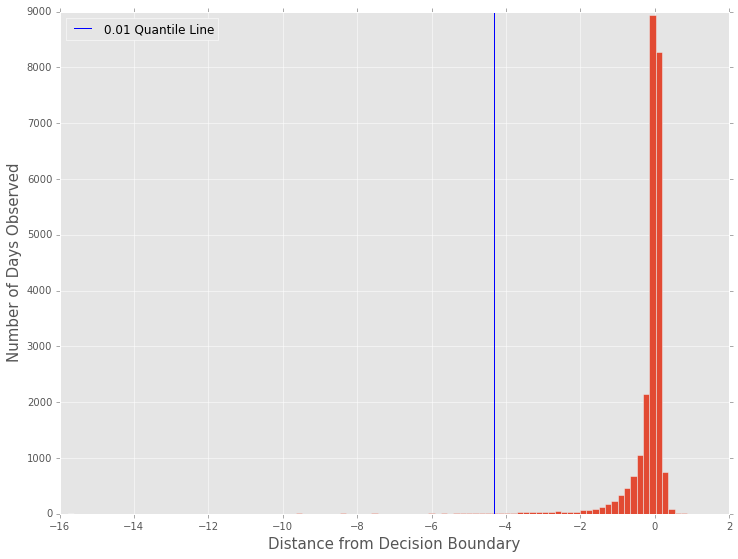

In [33]:
plt.figure(figsize=(12,9))
h = plt.hist(dists.flatten(), bins=100);
vl = plt.axvline(np.percentile(dists.flatten(), 1), label='0.01 Quantile Line')
plt.xlabel('Distance from Decision Boundary', fontsize=15)
plt.ylabel('Number of Days Observed', fontsize=15)
plt.legend(handles =[vl], loc=2, fontsize=12)

In [20]:
np.percentile(dists.flatten(), 1)

-4.3130556141960001